In [1]:
import networkx as nx
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

In [3]:
plt.rcParams["figure.figsize"] = (20,3)

In [4]:
from shared.constants import DatasetPath
from datasets.schema import DatasetSchema
from datasets.loading import load_igraph, igraph_to_nx

from datasets.visualization import plot_explore_dual_histogram, show_top_k_nodes, show_top_k_stacked_nodes

In [5]:
DATASET = DatasetPath('sx-superuser')
schema = DatasetSchema.load_schema(DATASET.name)
G = load_igraph(schema)

In [6]:
TIMESTAMP_BINS = 50
K = 10
HAS_NODE_TIMESTAMP = schema.is_node_temporal()
HAS_EDGE_TIMESTAMP = schema.is_edge_temporal()
BETWEENESS_K = 1

print('Has node timestamp: {}'.format(HAS_NODE_TIMESTAMP))
print('Has edge timestamp: {}'.format(HAS_EDGE_TIMESTAMP))

Has node timestamp: False
Has edge timestamp: True


# Dataset Specific Statistics

## Visualize Distribution of Nodes over Time

In [7]:
NODE_TIMESTAMPS = pd.Series(G.vs['timestamp'], name='timestamp', index=G.vs['name']) if HAS_NODE_TIMESTAMP else None
EDGE_TIMESTAMPS = pd.Series(G.es['timestamp'], name='timestamp', index=range(G.ecount())) if HAS_EDGE_TIMESTAMP else None
LABELS = pd.Series(G.vs['label'], name='label', index=G.vs['name'])

In [8]:
if HAS_NODE_TIMESTAMP:
    NODE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(NODE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Nodes over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Nodes')
else:
    print('No node timestamp data available')

No node timestamp data available


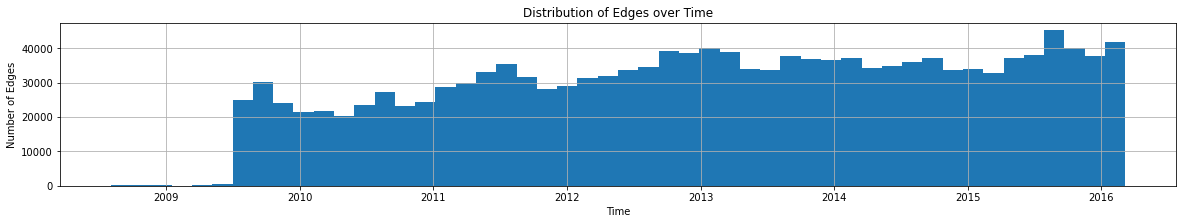

In [9]:
if HAS_EDGE_TIMESTAMP:
    EDGE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(EDGE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Edges over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Edges')
else:
    print('No edge timestamp data available')

# Global Statistics

In [10]:
print(f'Number of Nodes: {G.vcount()}')
print(f'Number of Edges: {G.ecount()}')
print(f'Density: {G.density()}')

Number of Nodes: 194085
Number of Edges: 1443339
Density: 7.663314269908676e-05


In [11]:
degrees = pd.Series(G.degree(), index=G.vs['name'])

In [12]:
print(f'Average Degree: {np.mean(degrees)}')
print(f'Median Degree: {np.median(degrees)}')

Average Degree: 14.873266867609553
Median Degree: 3.0


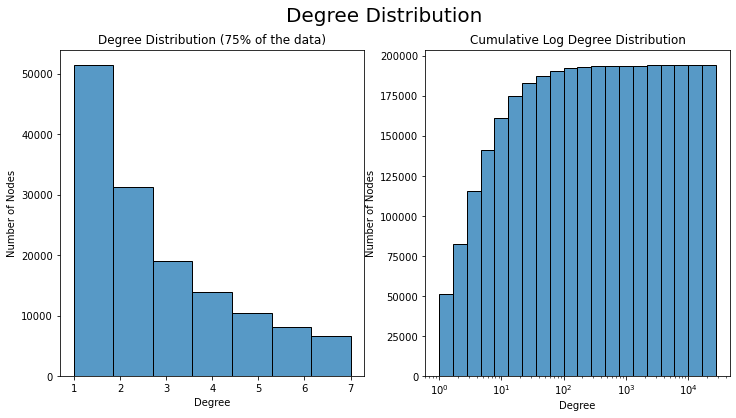

In [13]:
plot_explore_dual_histogram(
    series=degrees,
    title='Degree Distribution',
    title_short='Degree Distribution',
    xlabel='Degree',
    ylabel='Number of Nodes',
    normalize=False,
)
plt.show()

In [14]:
show_top_k_nodes(
    degrees,
    LABELS,
    title='Degree Nodes'
)

Top 10 Degree Nodes


,value,label
0,27637,83283
1,19727,8672
2,16408,23133
3,14801,48078
4,13533,1686
5,12014,40928
6,11804,10165
7,10925,337631
8,10110,174557
9,9433,138343


## Connectivity Metrics
* **degree_centrality**: Degree centrality of a node is the fraction of nodes it is connected to.
* **closeness_centrality**: Closeness centrality of a node is the inverse of the average shortest path length to all other nodes.
* **betweenness_centrality**: Betweenness centrality of a node is the fraction of all shortest paths in the network that pass through it.
* **eigenvector_centrality**: Eigenvector centrality of a node is the normalized sum of the eigenvector centralities of all its neighbors.
* **pagerank**: PageRank is a ranking of nodes based on the structure of the network.
* **transitivity**: Clustering coefficient is the fraction of triangles that are formed by a node and its neighbors.

In [15]:
# Use the largest connected component
G_cc = G.clusters().giant()

# Convert to NetworkX
nx_G = igraph_to_nx(G_cc)
nx_Gu = nx.Graph(nx_G)

In [16]:
print('Average Clustering Coefficient: {}'.format(nx.approximation.average_clustering(nx_Gu)))
print('Diameter: {}'.format(nx.approximation.diameter(nx_Gu)))

Average Clustering Coefficient: 0.217
Diameter: 11


In [17]:
# Calculate the metrics
metrics_dict = {}

metrics_dict['degree_centrality'] = nx.degree_centrality(nx_G)
try:
    metrics_dict['betweenness_centrality'] = nx.betweenness_centrality(nx_Gu, k=BETWEENESS_K)
except Exception as e:
    print('Betweenness Centrality Error: {}'.format(e))
try:
    metrics_dict['eigenvector_centrality'] = nx.eigenvector_centrality(nx_Gu)
except Exception as e:
    print('Eigenvector Centrality Error: {}'.format(e))
metrics_dict['page_rank'] = nx.pagerank(nx_Gu)
metrics_dict['transitivity'] = dict(zip(G_cc.vs['name'], G_cc.transitivity_local_undirected()))

NODE_STATS = pd.DataFrame(metrics_dict)
NODE_STATS.describe()

,degree_centrality,betweenness_centrality,eigenvector_centrality,page_rank,transitivity
count,189191.000000,189191.000000,1.891910e+05,189191.000000,119565.000000
mean,0.000080,0.000013,6.204263e-04,0.000005,0.188512
std,0.000816,0.001826,2.213766e-03,0.000043,0.299599
min,0.000005,0.000000,4.123157e-14,0.000001,0.000000
25%,0.000005,0.000000,1.925823e-05,0.000002,0.000000
50%,0.000016,0.000000,1.418075e-04,0.000002,0.035714
75%,0.000048,0.000000,6.118529e-04,0.000004,0.266667
max,0.146081,0.776593,2.097980e-01,0.010164,1.000000


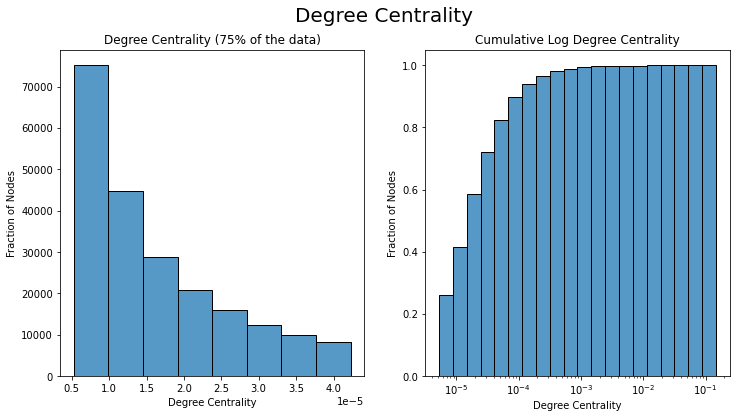

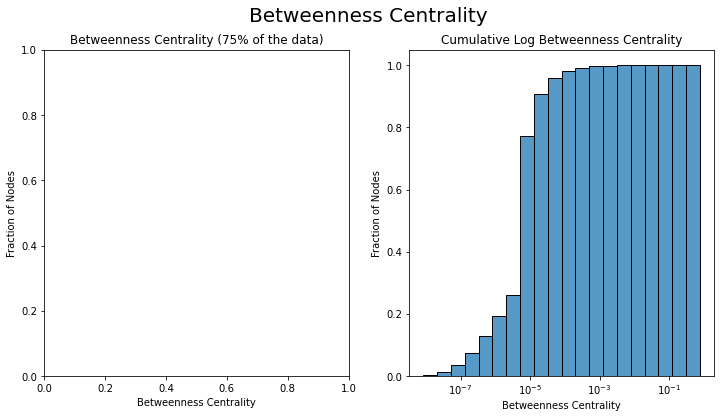

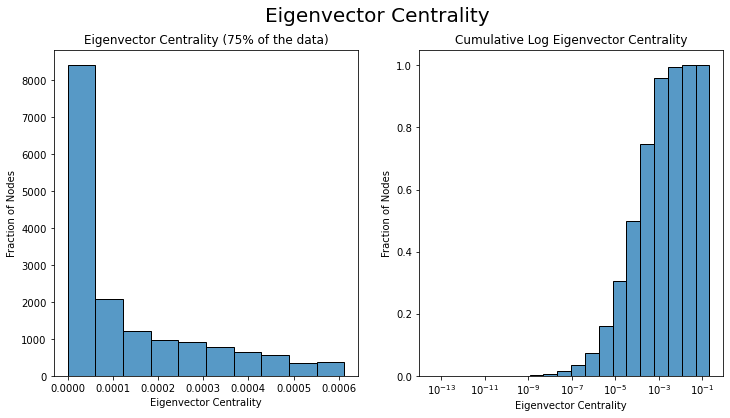

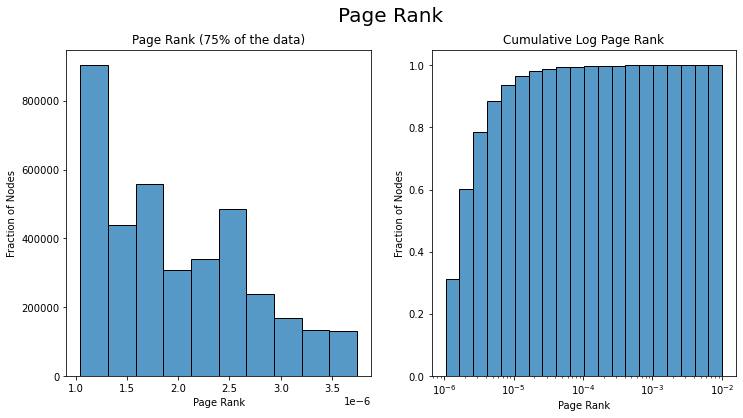

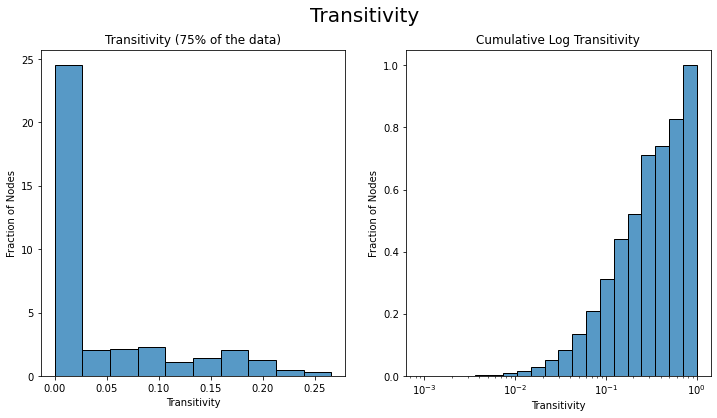

In [18]:
for col in NODE_STATS.columns:
    title = col.replace('_', ' ').title()
    data = NODE_STATS[col][np.isfinite(NODE_STATS[col])]
    try:
        plot_explore_dual_histogram(
            series=data,
            title=title,
            title_short=title,
            xlabel=title,
            ylabel='Fraction of Nodes',
            normalize=True,
        )
        plt.show()
    except:
        print(f'Failed to plot {title}')

In [19]:
show_top_k_stacked_nodes(
    NODE_STATS,
    LABELS,
    title='Nodes by Statistic',
)

Top 10 Nodes by Statistic


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.146081,83283,0.776593,1686,0.209798,83283,0.010164,83283,1.0,565974
1,0.104271,8672,0.107968,97396,0.157500,23133,0.005337,23133,1.0,266516
2,0.086728,23133,0.085959,51580,0.137123,8672,0.004578,337631,1.0,266697
3,0.078234,48078,0.067218,83283,0.133180,10165,0.004132,48078,1.0,266818
4,0.071531,1686,0.024693,23133,0.132948,1686,0.003168,40928,1.0,266832
5,0.063502,40928,0.023982,48078,0.131619,40928,0.003066,1686,1.0,266723
6,0.062392,10165,0.019728,126706,0.125951,48078,0.003015,10165,1.0,266378
7,0.057746,337631,0.016728,337631,0.100553,3279,0.002725,138343,1.0,266652
8,0.053438,174557,0.014013,10165,0.099574,4386,0.002433,174557,1.0,266621
9,0.049860,138343,0.013607,138343,0.092774,26316,0.002407,364367,1.0,266557


## Connected Components Statistics

In [20]:
print(f'Number of Connected Components: {len(G.components())}')
largest_cc = G.components().giant()
print(f'Size of the largest component: {largest_cc.vcount()}')

Number of Connected Components: 3197
Size of the largest component: 189191


Text(0.5, 1.0, 'Connected Components')

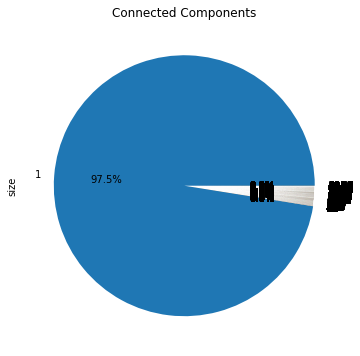

In [21]:
df_tmp = pd.DataFrame([{'size': len(c)} for i,c in enumerate(G.components())], index=range(1,len(G.components())+1))
ax = df_tmp.plot.pie(
    y='size',
    figsize=(6,6),
    autopct='%1.1f%%',
    legend=False,
)
ax.set_title('Connected Components')

# Type Specific Statistics

### Node Type Statistics

In [22]:
node_types = schema.get_node_types()
node_type_stats = pd.DataFrame([
    {
        'type': node_type,
        'count': len(G.vs.select(type=node_type)),
        'degree_avg': np.mean(G.vs.select(type=node_type).degree()),
        'degree_median': np.median(G.vs.select(type=node_type).degree()),
    }
    for node_type in node_types
], index=node_types)
print('Node Type count: {}'.format(len(node_types)))
node_type_stats

Node Type count: 1


,type,count,degree_avg,degree_median
User,User,194085,14.873267,3.0


<AxesSubplot:title={'center':'Node type counts'}, ylabel='count'>

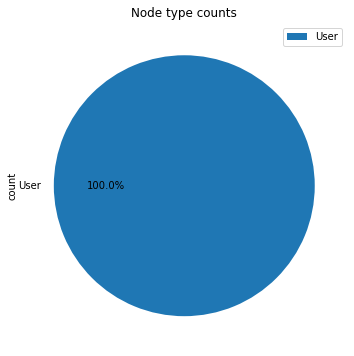

In [23]:
node_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Node type counts', figsize=(6,6))

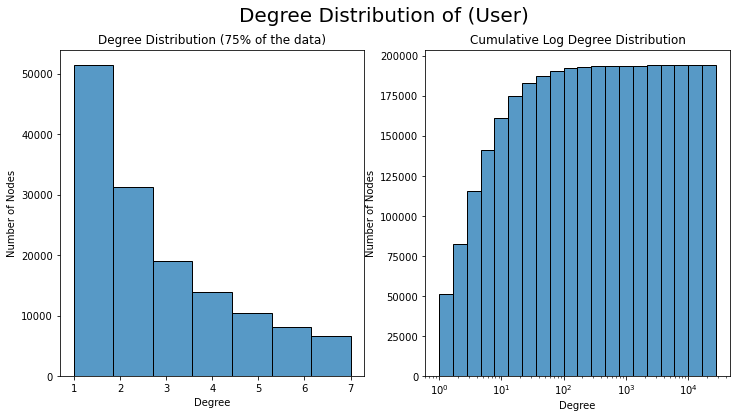

In [24]:
for node_type in node_types:
    degrees = pd.Series(G.vs.select(type=node_type).degree())
    plot_explore_dual_histogram(
        series=degrees,
        title=f'Degree Distribution of ({node_type})',
        title_short='Degree Distribution',
        xlabel='Degree',
        ylabel='Number of Nodes',
    )
    plt.show()

In [25]:
for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    data = pd.Series(nodes.degree(), index=nodes['name'])
    show_top_k_nodes(
        data,
        LABELS,
        title=f'Degree Nodes of Type ({node_type})'
    )

Top 10 Degree Nodes of Type (User)


,value,label
0,27637,83283
1,19727,8672
2,16408,23133
3,14801,48078
4,13533,1686
5,12014,40928
6,11804,10165
7,10925,337631
8,10110,174557
9,9433,138343


### Edge Type Statistics

In [26]:
edge_types = schema.get_edge_types()
edge_type_stats = pd.DataFrame([
    {
        'type': edge_type,
        'count': len(G.es.select(type=edge_type)),
    }
    for edge_type in edge_types
], index=edge_types)
print('Edge Type count: {}'.format(len(edge_types)))
edge_type_stats

Edge Type count: 3


,type,count
ANSWERED_QUESTION,ANSWERED_QUESTION,430033
COMMENTED_ON_QUESTION,COMMENTED_ON_QUESTION,479067
COMMENTED_ON_ANSWER,COMMENTED_ON_ANSWER,534239


<AxesSubplot:title={'center':'Edge type counts'}, ylabel='count'>

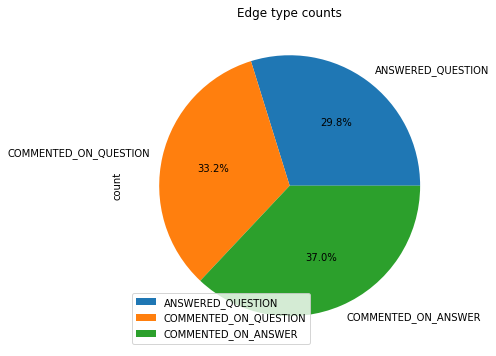

In [27]:
edge_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Edge type counts', figsize=(6,6))

## Node Type Connectivity Statistics

In [28]:
node_stats_by_type = {}

for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    names = set(nodes['name']) & set(NODE_STATS.index)

    node_stats_by_type[node_type] = NODE_STATS.loc[names]

In [29]:
for node_type in node_types:
    show_top_k_stacked_nodes(
        node_stats_by_type[node_type],
        LABELS,
        title=f'Nodes by Statistic for {node_type}',
    )

Top 10 Nodes by Statistic for User


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.146081,83283,0.776593,1686,0.209798,83283,0.010164,83283,1.0,426552
1,0.104271,8672,0.107968,97396,0.157500,23133,0.005337,23133,1.0,424263
2,0.086728,23133,0.085959,51580,0.137123,8672,0.004578,337631,1.0,424202
3,0.078234,48078,0.067218,83283,0.133180,10165,0.004132,48078,1.0,424211
4,0.071531,1686,0.024693,23133,0.132948,1686,0.003168,40928,1.0,503205
5,0.063502,40928,0.023982,48078,0.131619,40928,0.003066,1686,1.0,424217
6,0.062392,10165,0.019728,126706,0.125951,48078,0.003015,10165,1.0,424241
7,0.057746,337631,0.016728,337631,0.100553,3279,0.002725,138343,1.0,87985
8,0.053438,174557,0.014013,10165,0.099574,4386,0.002433,174557,1.0,539856
9,0.049860,138343,0.013607,138343,0.092774,26316,0.002407,364367,1.0,539858


# Clustering

## No Clustering Modularity

In [30]:
n = G_cc.vcount()
print(f'Initial modularity: {G_cc.modularity(np.ones(n))}')

Initial modularity: 0.0


### Louvain

In [31]:
louvain = G_cc.community_multilevel()
print(f'Modularity after Louvain: {G_cc.modularity(louvain)}')
print(f'Number of communities: {len(louvain)}')

Modularity after Louvain: 0.541186928963746
Number of communities: 140


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

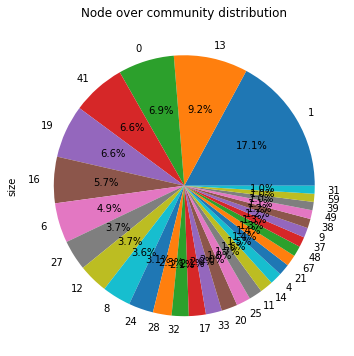

In [32]:
community_sizes = pd.Series(list(map(len, louvain)), name='size', index=range(len(louvain)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

In [33]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(louvain))):
    # Show top k nodes
    community_node_names = names.loc[louvain[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )

    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No node timestamp data available')

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.027137,364367,0.004849,150988,0.047292,97028,0.002407,364367,1.0,207217
1,0.025704,97028,0.004837,364367,0.046038,364367,0.002064,97028,1.0,239618
2,0.022950,116196,0.003593,97028,0.038524,116196,0.001605,116196,1.0,328788
3,0.017411,150988,0.003099,116196,0.036553,150988,0.001261,150988,1.0,225864
4,0.011322,50173,0.002662,76571,0.031263,50173,0.000704,50173,1.0,366499
5,0.007775,107753,0.002360,107753,0.021543,85564,0.000621,427317,1.0,203468
6,0.007722,76571,0.001629,111645,0.019204,5872,0.000603,76571,1.0,418510
7,0.007173,263458,0.001500,345527,0.018963,14596,0.000594,354511,1.0,161162
8,0.006538,145438,0.001332,346288,0.015250,145438,0.000576,107753,1.0,414586
9,0.006427,427317,0.001156,318069,0.014632,380110,0.000477,145438,1.0,149029


No node timestamp data available
Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.044157,4386,0.006114,4386,0.099574,4386,0.001300,4377,1.0,485714
1,0.039347,1931,0.005097,1931,0.086325,4377,0.001282,4386,1.0,2443
2,0.028590,4377,0.004337,4377,0.079748,1931,0.001054,482,1.0,38832
3,0.024541,482,0.003885,482,0.076959,289,0.001014,1931,1.0,48813
4,0.024119,12786,0.002544,289,0.069784,482,0.000810,289,1.0,20846
5,0.021402,289,0.002385,12786,0.059016,12786,0.000739,12786,1.0,25557
6,0.019605,310,0.002295,263,0.058847,13567,0.000719,310,1.0,234696
7,0.016153,16001,0.002154,310,0.057143,2127,0.000621,2013,1.0,25058
8,0.016058,13567,0.001927,13567,0.056654,16001,0.000595,13567,1.0,38145
9,0.015656,10674,0.001926,1548,0.056566,2013,0.000574,10674,1.0,15642


No node timestamp data available
Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.003230,92371,0.000774,84724,0.016996,92371,0.000156,84724,1.0,274779
1,0.002727,84724,0.000278,47108,0.011575,22536,0.000104,47108,1.0,335183
2,0.001913,47108,0.000252,92371,0.010165,47108,0.000097,22536,1.0,64602
3,0.001765,22536,0.000252,327572,0.008392,4525,0.000088,92371,1.0,233678
4,0.000914,58777,0.000224,4525,0.007364,84724,0.000066,327572,1.0,64537
5,0.000909,327572,0.000164,117589,0.006837,34953,0.000049,58777,1.0,545335
6,0.000803,4525,0.000147,22536,0.006323,117589,0.000046,4525,1.0,391374
7,0.000788,117589,0.000129,34953,0.006168,145121,0.000041,34953,1.0,414535
8,0.000777,34953,0.000093,116223,0.005203,327572,0.000036,145121,1.0,392752
9,0.000703,264276,0.000063,145121,0.004781,149971,0.000033,149971,1.0,112534


No node timestamp data available
Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.026640,52492,0.005905,52492,0.072241,52492,0.001176,52492,1.0,565016
1,0.003600,43008,0.000487,43008,0.021671,45861,0.000154,43008,1.0,84129
2,0.002437,45861,0.000413,45861,0.013405,43008,0.000109,45861,1.0,51111
3,0.001443,52063,0.000253,100444,0.012962,96273,0.000089,52063,1.0,140957
4,0.001432,11317,0.000223,52063,0.012576,52063,0.000078,122284,1.0,117426
5,0.001263,122284,0.000135,92302,0.009699,100444,0.000064,11317,1.0,142901
6,0.001189,112568,0.000112,49740,0.009155,106494,0.000056,100444,1.0,150913
7,0.001015,134148,0.000107,134148,0.009126,134148,0.000051,112568,1.0,142294
8,0.001004,96273,0.000099,60605,0.008457,92302,0.000049,92302,1.0,98758
9,0.000946,49740,0.000098,122284,0.008199,11317,0.000047,36719,1.0,118007


No node timestamp data available
Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.008045,68111,0.001457,85121,0.032985,68111,0.000437,85121,1.0,133353
1,0.006332,85121,0.000590,71027,0.025001,85121,0.000342,68111,1.0,168288
2,0.003827,71027,0.000507,1503,0.020398,71027,0.000193,71027,1.0,160827
3,0.003721,160458,0.000459,166801,0.018085,1503,0.000154,1503,1.0,9481
4,0.003547,1503,0.000425,68111,0.018079,112171,0.000134,147821,1.0,167988
5,0.002727,80304,0.000389,5142,0.017903,166801,0.000133,160458,1.0,35164
6,0.002643,147821,0.000349,80304,0.017535,5142,0.000128,166801,1.0,97716
7,0.002479,5142,0.000321,112171,0.016979,39091,0.000108,80304,1.0,174369
8,0.002336,166801,0.000265,5775,0.015950,160458,0.000104,5142,1.0,168273
9,0.002215,112171,0.000253,39091,0.015230,10686,0.000093,218928,1.0,129414


No node timestamp data available
Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.004466,281154,0.000641,278912,0.013648,281154,0.000227,281154,1.0,297108
1,0.002564,278912,0.000355,302409,0.008699,62313,0.000179,278912,1.0,326995
2,0.001686,302409,0.000255,281154,0.008192,35011,0.000103,332680,1.0,322015
3,0.001580,332680,0.000163,284567,0.006858,284567,0.000095,302409,1.0,68964
4,0.001269,35011,0.000137,332680,0.006797,15466,0.000075,245460,1.0,359874
5,0.001253,284567,0.000119,35011,0.006502,302409,0.000044,284567,1.0,306577
6,0.001152,245460,0.000110,62313,0.006317,33303,0.000040,19079,1.0,481957
7,0.000803,62313,0.000107,254119,0.006028,278912,0.000039,33303,1.0,345917
8,0.000772,33303,0.000103,33303,0.005071,232365,0.000038,35011,1.0,353115
9,0.000692,15466,0.000101,109158,0.004791,19079,0.000033,62313,1.0,317175


No node timestamp data available


### Label Propagation

In [34]:
label_prop = G_cc.community_label_propagation()
print(f'Modularity after Label Propagation: {G_cc.modularity(label_prop)}')
print(f'Number of communities: {len(label_prop)}')

Modularity after Label Propagation: 0.4263750934501147
Number of communities: 29468


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

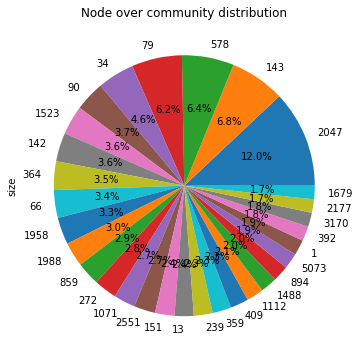

In [35]:
community_sizes = pd.Series(list(map(len, label_prop)), name='size', index=range(len(label_prop)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

In [36]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(label_prop))):
    # Show top k nodes
    community_node_names = names.loc[label_prop[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )


    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No timestamp data available')

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000164,833,0.000011,833,0.000862,833,0.000011,833,0.039216,833
1,0.000021,22284,0.000000,22284,0.000646,22284,0.000002,22284,0.000000,22284


No timestamp data available
Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.039347,1931,0.005097,1931,0.079748,1931,0.001014,1931,1.0,47445
1,0.001607,21729,0.000077,21729,0.013442,21729,0.000067,21729,1.0,9113
2,0.000825,3661,0.000052,11724,0.007943,11718,0.000040,11724,1.0,46809
3,0.000703,11724,0.000046,47992,0.006698,47992,0.000036,3230,1.0,65075
4,0.000671,3230,0.000036,11718,0.006526,3230,0.000029,3661,1.0,52413
5,0.000502,11718,0.000032,34340,0.005763,3661,0.000028,47992,1.0,8460
6,0.000476,11955,0.000029,17967,0.005544,3103,0.000027,11718,1.0,56310
7,0.000470,15916,0.000029,15813,0.005522,11724,0.000027,372751,1.0,65790
8,0.000407,372751,0.000026,12489,0.005097,11955,0.000024,1117,1.0,4094
9,0.000375,1117,0.000022,14685,0.004971,1117,0.000023,3103,1.0,124949


No timestamp data available
Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000640,169,0.000016,1580,2.681372e-03,1580,0.000030,169,0.333333,2705
1,0.000344,1580,0.000005,112030,2.527737e-03,169,0.000022,1580,0.085227,143
2,0.000217,143,0.000003,169,1.668013e-03,143,0.000013,143,0.077647,1580
3,0.000069,168,0.000002,143,8.614381e-04,168,0.000005,168,0.054545,168
4,0.000042,2705,0.000000,108305,2.973294e-04,235318,0.000004,112030,0.048101,169
5,0.000011,235318,0.000000,168,1.481294e-04,2705,0.000002,2705,0.000000,235318
6,0.000011,112030,0.000000,235318,1.274182e-05,112030,0.000002,112366,0.000000,112030
7,0.000005,108305,0.000000,112366,1.274154e-05,108305,0.000002,235318,NaN,108305
8,0.000005,112366,0.000000,2705,6.048147e-08,112366,0.000001,108305,NaN,112366


No timestamp data available
Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.001411,2366,0.000051,2366,0.012287,2366,0.000066,2366,0.081871,2829
1,0.000137,2829,0.000005,83115,0.001538,2829,0.000009,2829,0.069498,2366
2,0.000048,91791,0.000005,35720,0.000272,91791,0.000004,35720,0.000000,42550
3,0.000042,35720,0.000000,42550,0.000129,83115,0.000004,91791,0.000000,35720
4,0.000032,83115,0.000000,2829,0.000127,113918,0.000004,83115,0.000000,113918
5,0.000021,113918,0.000000,385552,0.000109,118804,0.000003,38528,0.000000,139843
6,0.000021,139843,0.000000,113918,0.000088,279343,0.000003,279343,0.000000,279343
7,0.000021,279343,0.000000,139843,0.000078,139843,0.000003,139843,0.000000,38528
8,0.000011,42550,0.000000,279343,0.000074,35720,0.000002,83182,0.000000,91791
9,0.000011,38528,0.000000,38528,0.000068,42550,0.000002,113918,0.000000,118804


No timestamp data available
Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.003150,90,0.000417,90,0.012963,90,0.000130,90,1.000000,152049
1,0.000174,1591,0.000007,4928,0.001110,1591,0.000011,1591,0.533333,872
2,0.000106,7520,0.000005,290639,0.000751,7520,0.000008,7520,0.133333,7520
3,0.000095,4928,0.000005,11931,0.000366,4928,0.000007,4928,0.043359,90
4,0.000048,872,0.000005,7520,0.000336,11931,0.000006,290639,0.038095,1591
5,0.000042,7233,0.000002,1591,0.000292,872,0.000003,11931,0.036364,4928
6,0.000026,11931,0.000000,137148,0.000254,137148,0.000003,265987,0.000000,7233
7,0.000021,265987,0.000000,11095,0.000186,11095,0.000003,151830,0.000000,11095
8,0.000016,50933,0.000000,151830,0.000163,152049,0.000003,872,0.000000,151830
9,0.000016,72017,0.000000,872,0.000121,239967,0.000002,110617,0.000000,3014


No timestamp data available
Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.003642,4358,6.617860e-05,4358,0.014874,4358,0.000136,4358,1.000000,8419
1,0.000640,5666,2.156387e-05,5666,0.003540,5666,0.000028,5666,0.666667,7029
2,0.000328,1000,1.585724e-05,1000,0.002637,1000,0.000017,1000,0.133333,6370
3,0.000095,12176,5.285748e-06,8427,0.000723,350050,0.000006,11904,0.103914,1000
4,0.000085,11904,6.218526e-07,5383,0.000658,33415,0.000006,33415,0.100000,8427
5,0.000069,8392,1.390986e-08,8392,0.000506,7029,0.000005,12176,0.090909,33415
6,0.000058,8427,0.000000e+00,230160,0.000369,12176,0.000004,8427,0.088889,12176
7,0.000058,33415,0.000000e+00,203616,0.000284,6370,0.000004,5383,0.066667,7568
8,0.000053,7568,0.000000e+00,538453,0.000277,11904,0.000004,8392,0.063388,5666
9,0.000042,6370,0.000000e+00,5803,0.000192,8392,0.000004,7568,0.043817,4358


No timestamp data available
